In [9]:
#Inports
import csv
import operator
import numpy as np
import json


import time
import geoplotlib
from geoplotlib.utils import BoundingBox
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats
import pylab as pl

import math
import random
random.seed(0)

<h1>Clustering (DSFS Chapter 19)</h1>
<h3>(For assignment 2)</h3>


> _Exercise_: $K$-means
> 
> * Visualize the prostitution data (e.g. by plotting it on a map)


In [2]:
def plotByCategory(category):
    listoflatitudes = []
    listoflongitudes = []

    with open("SFPD.csv", "r") as csvfile: #Opening the file
        reader = csv.DictReader(csvfile)
        for row in reader:                 #Going through each row in the file
            if row['Category'] == category:
                x = float(row['X'])
                y = float(row['Y'])
                listoflongitudes.append(x)
                listoflatitudes.append(y)

    geo_data_for_plotting = {"lat": listoflatitudes,
                             "lon": listoflongitudes}

    bbox = BoundingBox(north=37.790204, west=-122.509662, south=37.710767, east=-122.350000) #Bounding box fitted to LA
    geoplotlib.set_bbox(bbox)
    geoplotlib.dot(geo_data_for_plotting)

    geoplotlib.inline() #show plot in line

In [3]:
plotByCategory('PROSTITUTION')

> * Train models of $K = 2,\ldots,10$ on the prostitution data.

In [4]:
#First i make the input list of coordinates
inputForClusters = []
with open("SFPD.csv", "r") as csvfile: #Opening the file
        reader = csv.DictReader(csvfile)
        for row in reader: #Going through each row in the file
            if row['Category'] == 'PROSTITUTION':
                #Remove two corrdinates at 90.0, -120.5, which i assume is default for "unknown coordinates"
                if float(row['X']) == -120.5:
                    continue
                    
                coords = {}
                coords['x'] = float(row['X'])
                coords['y'] = float(row['Y'])   
                inputForClusters.append(coords)

In [11]:
#Defining KMeans class (Ref: DSFS p.226)
class KMeans:
    """performs k-means clustering"""
    def __init__(self, k):
        self.k = k # number of clusters
        self.means = None # means of clusters
    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))
    def train(self, inputs):
        # choose k random points as the initial means
        self.means = random.sample(inputs, self.k)
        assignments = None
        while True:
            # Find new assignments
            new_assignments = map(self.classify, inputs)
            # If no assignments have changed, we're done.
            if assignments == new_assignments:
                return
            # Otherwise keep the new assignments,
            assignments = new_assignments
            # And compute new means based on the new assignments
            for i in range(self.k):
                # find all the points assigned to cluster i
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # make sure i_points is not empty so don't divide by 0
                if i_points:
                    self.means[i] = vector_mean(i_points)
                    

def squared_distance(p1, p2):
    #Returns the squared distance between two points
    return pow(p1['x'] - p2['x'], 2) + pow(p1['y'] - p2['y'], 2)
        
def vector_mean(points):
    #Returns an average point(cluster) from a group of points
    xsum = 0
    ysum = 0
    for i in points:
        xsum = xsum + i['x']
        ysum = ysum + i['y']
    clusterCoords = {}
    clusterCoords['x'] = xsum/len(points)
    clusterCoords['y'] = ysum/len(points)
    return clusterCoords

clusters = []
for k in range(1, 11): #Creating the clusters with K = 2.... 10 on the data
    cluster = KMeans(k)
    cluster.train(inputForClusters)
    clusters.append(cluster)

In [17]:
#I want to show some of the data that i've created. This function can show it on a map of SF:
def showKMeansOnMap(kMeans, allPoints):
    #Formatting k-mean data for geoplotlib
    kMeanLat = []
    kMeanLon = []
    for k in kMeans:
        kMeanLon.append(k['x'])
        kMeanLat.append(k['y'])
    kMeanCoords = {"lat": kMeanLat, "lon": kMeanLon}

    #Formatting all occurences of prostitution for geoplotlib
    listoflatitudes = []
    listoflongitudes = []
    for k in allPoints:
        listoflongitudes.append(k['x'])
        listoflatitudes.append(k['y'])
    allOcc = {"lat": listoflatitudes, "lon": listoflongitudes}

    bbox = BoundingBox(north=37.790204, west=-122.509662, south=37.710767, east=-122.350000)
    geoplotlib.set_bbox(bbox)
    geoplotlib.dot(allOcc, point_size=2, color=[0, 0, 255]) #All occurences are blue
    geoplotlib.dot(kMeanCoords, point_size=6, color=[255, 0, 0]) #K-means are red

    geoplotlib.inline() #show plot in line

In [27]:
#Now i show 3 maps with K = 2, K = 4 and K = 10:
showKMeansOnMap(clusters[1].means, inputForClusters)
showKMeansOnMap(clusters[3].means, inputForClusters)
showKMeansOnMap(clusters[9].means, inputForClusters)

> * Explore how the total squared error changes as a function of $K$ and identify what you think is the right number of clusers based on the knee-point in the squared error plot.


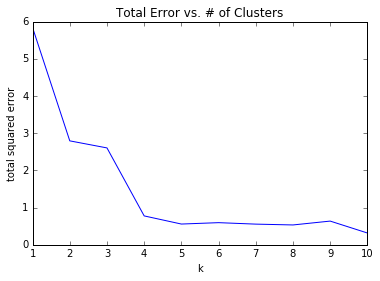

In [28]:
#Function that can calculate the squared clustering errors (from the book)
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = map(clusterer.classify, inputs)
    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

# now plot from 1 up to 10 clusters
ks = range(1, 11) 
errors = [squared_clustering_errors(inputForClusters, k) for k in ks]
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

As you can see in the plot there are two kneepoints. The first is at 2 clusters and the second is at 4 clusters. From 4 clusters the error-line pretty much stable which means it wont get much better increasing the number of clusters to more than 4.Therefore 4 is the best number of clusters here.

> * And by the way: The fit only gets better when we add more means - why not keep adding more of them: Explain in your own words why it makes sense to stop around a knee-point.

The whole point of a low amount of K-means is that we want to make a cluster to generalize data that are close together. Fitting with too many clusters doesn't give us the effect of generalization that we are looking for. 